In [1]:
#!/usr/bin/env python3

import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from IPython import display
from readcountclass import DiffGeneTable, make_responders_dict
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

In [8]:
#main_data_dir = sys.argv[1]
main_data_dir = "/Users/nicolasdeneuter/Bestanden/PhD/Projects/GOA/RNAseq/readcounts/ML_pipeline"
resp_dict = make_responders_dict(threshold = 100)
subdirmap = {}
fold_change = 7
padj_threshold = 0.1

# for each subdir in the main directory, find result files (each contrast has a different result file)
for x in os.walk(main_data_dir):
    subdir = x[0]
    if subdir == main_data_dir:
        continue
    data_files = glob(subdir+'/results*')
    # for each contrast's result:
    # make a dataframe containing a single row (ie one volunteer) containing log fold changes for each column/gene
    for data_file in data_files:
        # determine characteristics of file
        volunteer = data_file.split('/')[-2]
        contrast = data_file.split('/')[-1].replace('.txt','').replace('results_','')
        resp = resp_dict[volunteer]
        
        ## skip day 3 vs 7 contrast because it's the difference of the other contrasts
        #if contrast == '3_7':
        #    continue
        
        # read in and format data
        diff_gene_table = pd.read_csv(data_file).set_index('Unnamed: 0')
        
        # filter genes by fold change
        diff_gene_table = diff_gene_table[(diff_gene_table['log2FoldChange'] > fold_change)|\
                                              (diff_gene_table['log2FoldChange'] < -fold_change)]
        
        ## filter genes by adjusted p-value
        #diff_gene_table = diff_gene_table[diff_gene_table['padj'] <= padj_threshold]
        
        gene_folds = diff_gene_table.transpose().loc[['log2FoldChange']]
        gene_folds = gene_folds.rename(index={'log2FoldChange': '{}'.format(volunteer)}, 
                                       columns={name: '{}_{}'.format(name, contrast) for name in gene_folds.columns})
        gene_folds.columns.name = 'volunteer_resp'
        gene_folds = gene_folds[[x for x in gene_folds.columns if 'gene' in x]]
        subdirmap.setdefault(volunteer, []).append(gene_folds)
        display.display(gene_folds)

volunteer_resp,gene39885_0_3,gene9901_0_3,gene43946_0_3,gene6234_0_3,gene13175_0_3,gene239_0_3,gene3431_0_3,gene16262_0_3,gene8436_0_3,gene10705_0_3,...,gene9241_0_3,gene9289_0_3,gene9405_0_3,gene956_0_3,gene9560_0_3,gene9743_0_3,gene9864_0_3,gene9940_0_3,gene9957_0_3,gene9960_0_3
H10,-10.36731,10.704431,-9.60293,-9.504919,-9.533574,-9.693188,-10.309198,-10.101134,-9.752923,10.003004,...,7.724863,-8.823464,7.725935,8.625767,7.653763,-8.099533,8.196754,-9.726422,7.552907,-9.700016


volunteer_resp,gene1507_0_7,gene14620_0_7,gene30224_0_7,gene29940_0_7,gene9901_0_7,gene31371_0_7,gene45227_0_7,gene6234_0_7,gene21333_0_7,gene1190_0_7,...,gene9336_0_7,gene9369_0_7,gene9405_0_7,gene9448_0_7,gene9636_0_7,gene9743_0_7,gene9751_0_7,gene9766_0_7,gene982_0_7,gene9864_0_7
H10,10.12739,9.844956,-10.885317,11.478485,10.069397,9.933507,-11.193901,-10.84774,7.348439,10.12059,...,-8.62564,-7.064922,7.075118,8.455359,7.872555,-9.355676,-8.202186,-9.119189,-9.633558,7.561725


volunteer_resp,gene1507_3_7,gene14620_3_7,gene30224_3_7,gene22985_3_7,gene28815_3_7,gene29940_3_7,gene39885_3_7,gene31371_3_7,gene31764_3_7,gene39305_3_7,...,gene9038_3_7,gene9125_3_7,gene9198_3_7,gene9207_3_7,gene9369_3_7,gene9540_3_7,gene956_3_7,gene9732_3_7,gene9800_3_7,gene9992_3_7
H10,10.845795,10.501155,-7.408383,7.33568,11.699279,7.504913,9.741341,9.170571,-8.335547,10.091269,...,-7.93492,7.70326,8.240452,7.050606,-7.074058,7.570812,-10.531078,-7.422632,8.262307,8.691669


volunteer_resp,gene43626_0_3,gene47198_0_3,gene7992_0_3,gene28712_0_3,gene33160_0_3,gene32217_0_3,gene42938_0_3,gene33271_0_3,gene42486_0_3,gene34328_0_3,...,gene9632_0_3,gene9724_0_3,gene9789_0_3,gene9804_0_3,gene9816_0_3,gene9858_0_3,gene986_0_3,gene9956_0_3,gene9966_0_3,gene9978_0_3
H11,11.205101,7.745929,10.254782,7.091462,9.850926,9.921923,9.945181,10.141344,10.093768,8.382203,...,8.184559,7.642207,8.071227,8.452198,8.32829,8.47326,8.077557,8.079802,7.174412,9.382522


volunteer_resp,gene28777_0_7,gene1973_0_7,gene23628_0_7,gene18663_0_7,gene44069_0_7,gene13947_0_7,gene10868_0_7,gene625_0_7,gene1004_0_7,gene10280_0_7,...,gene8909_0_7,gene896_0_7,gene8960_0_7,gene9192_0_7,gene9537_0_7,gene9724_0_7,gene9770_0_7,gene9833_0_7,gene9849_0_7,gene9927_0_7
H11,7.937288,-10.223316,-8.122828,-7.206138,-9.352635,8.186748,-9.628914,8.466092,7.040108,7.497941,...,7.454218,8.413362,7.996547,8.339788,8.843803,8.022801,7.250202,7.279879,7.155961,7.312387


volunteer_resp,gene43626_3_7,gene7992_3_7,gene50267_3_7,gene33160_3_7,gene40873_3_7,gene32217_3_7,gene42938_3_7,gene48873_3_7,gene33271_3_7,gene42486_3_7,...,gene9373_3_7,gene9383_3_7,gene9632_3_7,gene9803_3_7,gene986_3_7,gene9861_3_7,gene9893_3_7,gene9956_3_7,gene9978_3_7,gene9998_3_7
H11,-10.095487,-11.117385,-7.412643,-10.831812,-7.244955,-9.798048,-10.049173,-7.268954,-9.803345,-9.609945,...,-7.734951,-7.091249,-7.481342,-8.27651,-8.255249,7.406317,-9.456715,-8.779297,-8.537173,-7.603506


volunteer_resp,gene4885_0_3,gene32239_0_3,gene32393_0_3,gene1096_0_3,gene35503_0_3,gene8988_0_3,gene8298_0_3,gene41680_0_3,gene31368_0_3,gene47996_0_3,...,gene49412_0_3,gene5262_0_3,gene5276_0_3,gene5884_0_3,gene6553_0_3,gene705_0_3,gene8306_0_3,gene8573_0_3,gene9001_0_3,gene9971_0_3
H13,-7.66818,-11.786677,-11.303672,10.678141,-10.426568,-7.027794,-9.962628,8.494663,9.433215,9.243197,...,7.188265,-7.334968,-7.162009,-7.908084,7.071534,7.410373,-7.205491,-8.18724,7.046693,7.087742


volunteer_resp,gene4885_0_7,gene32239_0_7,gene32393_0_7,gene35503_0_7,gene8298_0_7,gene45303_0_7,gene30561_0_7,gene39112_0_7,gene43297_0_7,gene32955_0_7,...,gene7588_0_7,gene7652_0_7,gene7999_0_7,gene85_0_7,gene879_0_7,gene8836_0_7,gene8925_0_7,gene8981_0_7,gene9478_0_7,gene9864_0_7
H13,-7.03822,-11.745313,-11.220164,-8.567032,-9.235092,-9.333983,-8.61478,10.004306,-8.861767,-9.810775,...,-7.532662,-7.651856,7.732077,-8.012353,7.422635,7.65188,-7.81143,-7.068292,7.230778,-7.080975


volunteer_resp,gene1096_3_7,gene22439_3_7,gene41680_3_7,gene31368_3_7,gene47996_3_7,gene45611_3_7,gene101_3_7,gene27467_3_7,gene31167_3_7,gene34940_3_7,...,gene6962_3_7,gene7525_3_7,gene7640_3_7,gene7641_3_7,gene7710_3_7,gene85_3_7,gene8785_3_7,gene8925_3_7,gene9773_3_7,gene9899_3_7
H13,-9.453021,-7.333702,-9.475455,-8.92751,-9.187571,-8.883133,8.813952,-9.091674,-9.458135,-8.878036,...,-7.324413,-7.044133,-7.365204,-7.112453,-7.293052,-7.403538,7.049081,-7.202631,-7.563924,-7.003631


volunteer_resp,gene10314_0_3,gene10391_0_3,gene10437_0_3,gene10566_0_3,gene10628_0_3,gene11355_0_3,gene11593_0_3,gene11816_0_3,gene12356_0_3,gene1252_0_3,...,gene7513_0_3,gene7658_0_3,gene7899_0_3,gene7911_0_3,gene805_0_3,gene8861_0_3,gene9082_0_3,gene9407_0_3,gene9803_0_3,gene9864_0_3
H14,-8.747745,-7.291556,8.405625,8.576278,-8.584012,7.960755,7.528525,7.183217,7.253911,7.980084,...,-8.59836,9.198541,7.824155,-8.245213,7.030086,7.771889,7.312978,7.184444,7.031785,7.551988


volunteer_resp,gene10075_0_7,gene10180_0_7,gene10280_0_7,gene10391_0_7,gene10583_0_7,gene10628_0_7,gene10868_0_7,gene1094_0_7,gene12335_0_7,gene12424_0_7,...,gene6711_0_7,gene7779_0_7,gene7936_0_7,gene805_0_7,gene8403_0_7,gene8407_0_7,gene8554_0_7,gene873_0_7,gene9355_0_7,gene999_0_7
H14,7.822614,7.37465,7.173006,-7.890458,7.246149,-8.297808,-8.646768,7.100974,7.464558,7.665349,...,-7.646032,7.345161,-7.869183,7.138223,7.802166,7.324132,7.40518,8.034322,7.698324,7.04392


volunteer_resp,gene10124_3_7,gene10192_3_7,gene10280_3_7,gene10314_3_7,gene10566_3_7,gene1057_3_7,gene1067_3_7,gene1070_3_7,gene1098_3_7,gene11280_3_7,...,gene887_3_7,gene8960_3_7,gene9082_3_7,gene9169_3_7,gene9239_3_7,gene9243_3_7,gene9367_3_7,gene9502_3_7,gene9725_3_7,gene9864_3_7
H14,8.305596,-7.233342,7.472226,8.363376,-7.325301,-8.199601,-7.368821,-7.71624,-8.389186,-8.542773,...,8.547179,-7.815006,-7.593127,-7.241883,-7.331402,7.329997,7.835096,7.016759,-7.251546,-7.875501


volunteer_resp,gene48814_0_3,gene21714_0_3,gene34734_0_3,gene33024_0_3,gene8073_0_3,gene11897_0_3,gene1298_0_3,gene23152_0_3,gene23783_0_3,gene29087_0_3,...,gene8808_0_3,gene9061_0_3,gene9124_0_3,gene9148_0_3,gene9239_0_3,gene9286_0_3,gene9308_0_3,gene9364_0_3,gene9542_0_3,gene9971_0_3
H17,-8.021441,-7.54704,7.9355,9.16607,-9.901471,7.259109,-9.665525,-10.235671,8.949557,-8.099874,...,7.271507,-8.937667,-7.788925,8.240227,7.146927,7.069509,-8.061126,7.294187,-7.091253,-8.55087


volunteer_resp,gene10400_0_7,gene28350_0_7,gene30612_0_7,gene17335_0_7,gene21714_0_7,gene41576_0_7,gene5103_0_7,gene7941_0_7,gene3402_0_7,gene3969_0_7,...,gene9286_0_7,gene9309_0_7,gene9502_0_7,gene9660_0_7,gene9721_0_7,gene9776_0_7,gene9806_0_7,gene9865_0_7,gene9877_0_7,gene9937_0_7
H17,9.94907,10.399844,7.545757,7.157581,-10.514566,-7.019577,9.581835,8.36806,7.367749,7.913734,...,7.328591,9.689637,-7.341316,7.455463,7.916426,7.612263,-7.946274,-7.271552,8.227553,7.386624


volunteer_resp,gene10400_3_7,gene15524_3_7,gene28350_3_7,gene30612_3_7,gene17335_3_7,gene20339_3_7,gene34734_3_7,gene44114_3_7,gene5103_3_7,gene14490_3_7,...,gene9251_3_7,gene9308_3_7,gene9355_3_7,gene9364_3_7,gene9417_3_7,gene9450_3_7,gene9540_3_7,gene9877_3_7,gene9899_3_7,gene9992_3_7
H17,10.771314,9.926793,10.90186,10.375333,10.579872,10.008735,-10.346361,7.0701,10.029724,10.076182,...,7.026861,7.74178,7.747739,-7.989144,7.411548,7.428954,-8.588785,7.711505,-8.344923,-9.747634


volunteer_resp,gene10007_0_3,gene10180_0_3,gene10198_0_3,gene10628_0_3,gene1094_0_3,gene11209_0_3,gene11332_0_3,gene11490_0_3,gene11494_0_3,gene11673_0_3,...,gene8491_0_3,gene8573_0_3,gene8574_0_3,gene9124_0_3,gene928_0_3,gene9362_0_3,gene9423_0_3,gene9505_0_3,gene957_0_3,gene9746_0_3
H19,8.681749,-7.835944,8.021289,-7.540529,7.063413,-7.079901,7.757638,-7.160511,7.452534,-7.466468,...,7.772039,-7.665498,-7.203966,7.664293,7.595347,8.06599,7.265737,7.671266,-9.268333,-8.055844


volunteer_resp,gene10180_0_7,gene10280_0_7,gene10513_0_7,gene10524_0_7,gene10735_0_7,gene1098_0_7,gene11171_0_7,gene11490_0_7,gene11512_0_7,gene11603_0_7,...,gene8489_0_7,gene8574_0_7,gene8646_0_7,gene8803_0_7,gene9061_0_7,gene912_0_7,gene933_0_7,gene9423_0_7,gene9766_0_7,gene9849_0_7
H19,-7.571349,-7.423995,-7.029223,-7.44362,-7.50701,8.648063,-8.288857,-7.255118,-7.41405,-7.77195,...,7.141193,-7.047181,7.19425,-8.506006,-9.158172,-7.63479,-7.682392,7.031404,-7.339982,-8.351454


volunteer_resp,gene10007_3_7,gene10638_3_7,gene10724_3_7,gene11144_3_7,gene11494_3_7,gene11535_3_7,gene1190_3_7,gene12124_3_7,gene12206_3_7,gene12424_3_7,...,gene8742_3_7,gene8751_3_7,gene8803_3_7,gene9048_3_7,gene9055_3_7,gene9116_3_7,gene9806_3_7,gene9849_3_7,gene9950_3_7,gene9998_3_7
H19,-7.218585,7.204203,-7.111861,7.561498,-7.949097,7.029365,-8.254803,7.747613,-7.015791,-7.238409,...,7.213841,-7.711632,-7.771389,7.534941,-8.055176,7.025794,7.064013,-7.616858,-7.716532,-7.412364


volunteer_resp,gene10075_0_3,gene39982_0_3,gene32083_0_3,gene16267_0_3,gene25161_0_3,gene30507_0_3,gene15275_0_3,gene36453_0_3,gene14275_0_3,gene21086_0_3,...,gene9505_0_3,gene956_0_3,gene9614_0_3,gene970_0_3,gene9710_0_3,gene9773_0_3,gene98_0_3,gene9803_0_3,gene9849_0_3,gene9940_0_3
H2,-7.961752,9.593627,-7.150215,-10.355188,-7.598137,-10.836691,8.943851,9.492678,-7.329969,-10.181101,...,7.985663,-8.426597,7.548845,7.04063,8.070489,-7.790222,-7.896665,8.435108,-9.561849,7.06583


volunteer_resp,gene12107_0_7,gene37412_0_7,gene28883_0_7,gene32083_0_7,gene3164_0_7,gene47966_0_7,gene46281_0_7,gene30507_0_7,gene16769_0_7,gene7540_0_7,...,gene9694_0_7,gene970_0_7,gene9773_0_7,gene9800_0_7,gene9823_0_7,gene9849_0_7,gene990_0_7,gene9901_0_7,gene9952_0_7,gene9992_0_7
H2,7.488953,9.120603,8.743732,-7.411386,7.210619,10.130184,-10.453678,-9.029806,8.26396,8.17661,...,7.028555,7.213157,-7.230488,-7.475972,7.751237,-8.617589,8.392835,8.162961,8.171218,-7.216242


volunteer_resp,gene10075_3_7,gene12107_3_7,gene37412_3_7,gene28883_3_7,gene39982_3_7,gene16267_3_7,gene8359_3_7,gene46281_3_7,gene16769_3_7,gene38730_3_7,...,gene8534_3_7,gene8566_3_7,gene8670_3_7,gene9_3_7,gene9002_3_7,gene9048_3_7,gene9354_3_7,gene98_3_7,gene9804_3_7,gene990_3_7
H2,10.157858,11.00101,10.9205,11.279974,-10.348849,9.600829,8.68608,-9.539461,10.450147,9.283134,...,-7.114004,7.033503,-7.290449,7.089107,-7.997543,-8.227576,-7.160394,7.005135,-7.413714,7.255444


volunteer_resp,gene10202_0_3,gene10386_0_3,gene10589_0_3,gene10705_0_3,gene10904_0_3,gene10919_0_3,gene1102_0_3,gene11210_0_3,gene11355_0_3,gene11885_0_3,...,gene7331_0_3,gene7526_0_3,gene7645_0_3,gene8084_0_3,gene8230_0_3,gene8427_0_3,gene85_0_3,gene9101_0_3,gene9138_0_3,gene9653_0_3
H20,8.314102,-7.026524,-8.526944,-7.314794,7.593841,-7.996555,8.305497,-7.305126,7.843744,-8.781265,...,7.932694,-7.118708,-7.213686,-7.365982,-7.241801,7.864099,7.622765,8.424678,-7.508993,8.302193


volunteer_resp,gene0_0_7,gene10007_0_7,gene10180_0_7,gene10315_0_7,gene10415_0_7,gene10436_0_7,gene10457_0_7,gene10589_0_7,gene10700_0_7,gene10705_0_7,...,gene85_0_7,gene8554_0_7,gene8629_0_7,gene8803_0_7,gene9239_0_7,gene9454_0_7,gene95_0_7,gene9632_0_7,gene9636_0_7,gene990_0_7
H20,7.149979,8.16653,7.18412,7.163337,7.37172,7.738469,-7.986002,-8.702225,-8.828858,-8.299315,...,7.34857,7.421889,8.333125,7.013277,7.80429,9.151221,7.204686,7.390369,8.713144,8.357047


volunteer_resp,gene10111_3_7,gene10163_3_7,gene10315_3_7,gene10437_3_7,gene10442_3_7,gene10594_3_7,gene10904_3_7,gene10911_3_7,gene11070_3_7,gene11092_3_7,...,gene9046_3_7,gene9101_3_7,gene9125_3_7,gene9322_3_7,gene9392_3_7,gene9454_3_7,gene9653_3_7,gene9751_3_7,gene9852_3_7,gene9868_3_7
H20,-8.699063,-7.260431,7.226474,7.520269,8.019757,7.354401,-9.203333,8.631217,7.619349,7.194538,...,-7.162699,-7.675851,7.33616,7.950089,-7.154244,7.270558,-7.292895,7.725391,-8.073521,-7.351219


volunteer_resp,gene22448_0_3,gene29902_0_3,gene4354_0_3,gene44402_0_3,gene319_0_3,gene48924_0_3,gene24087_0_3,gene10111_0_3,gene10167_0_3,gene10194_0_3,...,gene8921_0_3,gene9048_0_3,gene905_0_3,gene9138_0_3,gene9210_0_3,gene9251_0_3,gene9461_0_3,gene9547_0_3,gene9934_0_3,gene9940_0_3
H21,10.143584,9.318996,8.920505,-10.49148,8.431135,-9.660238,7.821079,7.876275,7.93402,7.020212,...,-7.839137,-9.784663,7.302642,-8.36425,-7.420454,7.255759,-7.984622,-7.068979,8.247143,7.122491


volunteer_resp,gene44402_0_7,gene19150_0_7,gene31424_0_7,gene14602_0_7,gene23178_0_7,gene25594_0_7,gene10030_0_7,gene10255_0_7,gene10295_0_7,gene10479_0_7,...,gene8493_0_7,gene8594_0_7,gene863_0_7,gene8742_0_7,gene9048_0_7,gene9110_0_7,gene956_0_7,gene9808_0_7,gene9937_0_7,gene9940_0_7
H21,-8.924055,8.383179,9.317952,-9.39606,9.038011,9.29511,8.575101,7.779787,7.120681,7.755734,...,7.441704,-8.286542,7.26115,7.878483,-7.018289,7.83266,7.222614,7.046351,7.070975,7.272133


volunteer_resp,gene29902_3_7,gene17096_3_7,gene4354_3_7,gene19150_3_7,gene31424_3_7,gene319_3_7,gene48924_3_7,gene14602_3_7,gene6050_3_7,gene24087_3_7,...,gene905_3_7,gene9110_3_7,gene9195_3_7,gene9251_3_7,gene9271_3_7,gene9361_3_7,gene9808_3_7,gene9849_3_7,gene9937_3_7,gene9957_3_7
H21,-10.136861,-9.761078,-9.242161,9.399994,8.324971,-9.085646,8.820361,-8.40653,9.249808,-9.089139,...,-8.005339,8.537077,-7.456709,-7.005425,-7.254606,-8.402953,7.967452,7.301339,7.17876,-7.085505


volunteer_resp,gene7309_0_3,gene28826_0_3,gene4884_0_3,gene17105_0_3,gene22141_0_3,gene14982_0_3,gene27098_0_3,gene17132_0_3,gene11240_0_3,gene27549_0_3,...,gene9276_0_3,gene9305_0_3,gene9308_0_3,gene9407_0_3,gene9516_0_3,gene9521_0_3,gene972_0_3,gene9800_0_3,gene9843_0_3,gene9956_0_3
H22,-10.293849,-7.061218,7.399996,9.580195,8.147118,10.18674,-9.142581,9.85707,9.367885,-10.273501,...,9.952528,7.719316,7.67073,-9.055498,-8.344104,7.488255,-7.258031,-7.160128,7.956057,8.780374


volunteer_resp,gene7309_0_7,gene1231_0_7,gene18796_0_7,gene27098_0_7,gene39446_0_7,gene27549_0_7,gene33208_0_7,gene1067_0_7,gene44996_0_7,gene37143_0_7,...,gene9150_0_7,gene9152_0_7,gene9160_0_7,gene9251_0_7,gene9276_0_7,gene9406_0_7,gene9407_0_7,gene9543_0_7,gene9630_0_7,gene9956_0_7
H22,-10.668251,9.524978,9.285196,-10.412662,-7.803057,-7.701439,-9.862332,9.093698,9.368854,7.563197,...,7.226381,-8.463648,-9.29626,7.026533,9.059546,8.082779,-7.238094,-7.207675,-8.726059,7.887394


volunteer_resp,gene28826_3_7,gene37989_3_7,gene17105_3_7,gene22141_3_7,gene1231_3_7,gene18796_3_7,gene14982_3_7,gene17132_3_7,gene11240_3_7,gene3133_3_7,...,gene9060_3_7,gene9100_3_7,gene9150_3_7,gene9166_3_7,gene9425_3_7,gene9463_3_7,gene9521_3_7,gene9601_3_7,gene9823_3_7,gene991_3_7
H22,9.90912,9.890747,-10.370794,-10.331576,9.497733,9.556648,-9.172206,-10.035182,-10.135475,-9.785253,...,8.043696,-7.847529,8.624454,-7.451696,7.212591,8.38973,-7.698539,7.406211,7.183851,7.143672


volunteer_resp,gene14044_0_3,gene16245_0_3,gene39041_0_3,gene39324_0_3,gene42735_0_3,gene44844_0_3,gene49512_0_3,gene4649_0_3,gene13973_0_3,gene45550_0_3,...,gene873_0_3,gene8921_0_3,gene9207_0_3,gene9346_0_3,gene9603_0_3,gene9710_0_3,gene9774_0_3,gene979_0_3,gene9851_0_3,gene9998_0_3
H23,-9.535836,-8.674934,-9.800862,-7.302553,-9.956534,9.892063,-9.432401,8.802353,-10.053581,-9.636603,...,-8.24887,8.614311,-7.014077,7.28677,7.088805,7.996487,7.05361,-7.076583,-7.168872,7.582096


volunteer_resp,gene15825_0_7,gene32070_0_7,gene37091_0_7,gene46492_0_7,gene16472_0_7,gene38069_0_7,gene32641_0_7,gene12459_0_7,gene16245_0_7,gene26728_0_7,...,gene9199_0_7,gene9448_0_7,gene956_0_7,gene9581_0_7,gene9622_0_7,gene9710_0_7,gene9725_0_7,gene9800_0_7,gene9820_0_7,gene990_0_7
H23,9.662942,9.324476,9.896841,7.620001,7.984036,9.45226,9.993618,8.852873,-10.284663,8.049158,...,-8.17154,-7.179883,7.724578,7.143189,-7.753609,7.347591,-7.125439,7.340191,7.223991,7.54541


volunteer_resp,gene15825_3_7,gene32070_3_7,gene16472_3_7,gene38069_3_7,gene32641_3_7,gene12459_3_7,gene14044_3_7,gene26728_3_7,gene39041_3_7,gene45191_3_7,...,gene9148_3_7,gene9164_3_7,gene933_3_7,gene9405_3_7,gene9448_3_7,gene9630_3_7,gene9723_3_7,gene9725_3_7,gene987_3_7,gene990_3_7
H23,8.999178,9.639727,9.848666,9.528034,7.952602,9.550555,8.87237,10.013059,9.137404,9.574182,...,7.554683,7.610669,-7.617701,-8.216233,-7.147693,8.100565,7.250617,-7.110803,7.862652,7.507723


volunteer_resp,gene33774_0_3,gene15087_0_3,gene5387_0_3,gene32781_0_3,gene13566_0_3,gene10018_0_3,gene10021_0_3,gene10074_0_3,gene10078_0_3,gene10095_0_3,...,gene9065_0_3,gene9124_0_3,gene9125_0_3,gene9138_0_3,gene9196_0_3,gene9254_0_3,gene987_0_3,gene991_0_3,gene9913_0_3,gene9956_0_3
H24,7.83548,-9.641211,7.050938,-9.258688,7.802873,7.760782,-7.001354,7.041933,8.221109,-8.182866,...,7.765981,7.173676,-8.24053,-7.903203,-7.9837,7.230334,7.993351,8.543524,7.668139,8.482655


volunteer_resp,gene22919_0_7,gene11098_0_7,gene15087_0_7,gene32639_0_7,gene32781_0_7,gene4941_0_7,gene1713_0_7,gene29674_0_7,gene10095_0_7,gene10124_0_7,...,gene9125_0_7,gene9129_0_7,gene9138_0_7,gene9166_0_7,gene9407_0_7,gene9417_0_7,gene9448_0_7,gene9492_0_7,gene9656_0_7,gene9992_0_7
H24,-8.285707,-7.516311,-10.81068,-7.044206,-10.842189,-7.118143,7.017927,7.565319,-8.827054,-7.432332,...,-9.269696,7.086982,-8.467636,7.546055,7.705119,7.343946,-8.290955,-9.4519,-8.459649,7.203635


volunteer_resp,gene4885_3_7,gene33774_3_7,gene29727_3_7,gene255_3_7,gene18722_3_7,gene9338_3_7,gene34306_3_7,gene28822_3_7,gene0_3_7,gene10018_3_7,...,gene8960_3_7,gene9008_3_7,gene9072_3_7,gene9211_3_7,gene9280_3_7,gene9289_3_7,gene9492_3_7,gene987_3_7,gene991_3_7,gene9998_3_7
H24,7.506392,-10.784865,-7.072289,7.900655,7.990027,-7.9086,-7.128009,7.607149,9.443162,-8.858197,...,9.240705,7.392554,-7.478458,-7.149509,-7.750723,7.751248,-9.269752,-7.165856,-9.407392,7.852139


volunteer_resp,gene44365_0_3,gene10129_0_3,gene1109_0_3,gene11217_0_3,gene11341_0_3,gene11520_0_3,gene11616_0_3,gene11628_0_3,gene11673_0_3,gene11689_0_3,...,gene8426_0_3,gene8447_0_3,gene858_0_3,gene8751_0_3,gene8808_0_3,gene8981_0_3,gene8993_0_3,gene9422_0_3,gene9706_0_3,gene9960_0_3
H25,9.957795,7.35306,7.248463,7.569726,7.959061,-7.330258,-7.091799,-7.34709,7.225459,7.356512,...,-7.114376,7.517577,8.145384,8.091733,7.969754,8.317566,-7.49911,7.308914,-7.205237,7.904859


volunteer_resp,gene44709_0_7,gene44365_0_7,gene21854_0_7,gene0_0_7,gene10009_0_7,gene10382_0_7,gene10527_0_7,gene10811_0_7,gene10941_0_7,gene11117_0_7,...,gene8993_0_7,gene9060_0_7,gene9239_0_7,gene9392_0_7,gene956_0_7,gene9672_0_7,gene9746_0_7,gene9776_0_7,gene9806_0_7,gene999_0_7
H25,9.749944,9.435537,-9.190512,8.358326,7.648332,7.534078,7.109831,7.411418,7.580696,7.765413,...,-8.393154,-9.048649,7.145473,7.168986,7.583455,-7.034603,-7.528023,7.05348,7.213728,7.96157


volunteer_resp,gene44709_3_7,gene21854_3_7,gene0_3_7,gene10009_3_7,gene10527_3_7,gene10529_3_7,gene10535_3_7,gene10645_3_7,gene10671_3_7,gene10762_3_7,...,gene8241_3_7,gene839_3_7,gene8426_3_7,gene8667_3_7,gene9001_3_7,gene9002_3_7,gene9311_3_7,gene9406_3_7,gene9445_3_7,gene9672_3_7
H25,9.923425,-9.852961,7.894718,8.375332,8.294481,-7.391815,7.034954,-7.525169,-7.054091,-7.650809,...,-7.512547,-7.082435,7.254606,-7.260154,-7.082435,-8.3271,-7.374274,8.260219,-7.054091,-7.697085


volunteer_resp,gene15954_0_3,gene41790_0_3,gene48395_0_3,gene50368_0_3,gene18455_0_3,gene22984_0_3,gene45191_0_3,gene17954_0_3,gene9161_0_3,gene24640_0_3,...,gene9369_0_3,gene946_0_3,gene9581_0_3,gene9660_0_3,gene98_0_3,gene986_0_3,gene9899_0_3,gene991_0_3,gene9960_0_3,gene9981_0_3
H26,8.271861,9.875585,9.23369,9.254386,9.766004,7.429643,10.254414,8.973582,7.76903,9.998908,...,7.254583,7.038302,7.156486,7.840279,7.252372,7.227152,7.974488,7.69992,-7.200592,-7.783947


volunteer_resp,gene24677_0_7,gene45325_0_7,gene50216_0_7,gene8441_0_7,gene23716_0_7,gene7101_0_7,gene9338_0_7,gene24339_0_7,gene49136_0_7,gene50256_0_7,...,gene896_0_7,gene8998_0_7,gene9166_0_7,gene9522_0_7,gene9549_0_7,gene961_0_7,gene9622_0_7,gene9624_0_7,gene9678_0_7,gene9773_0_7
H26,-10.653989,10.575603,8.631989,-8.344116,7.001678,8.56613,7.185264,-10.173503,10.314504,10.827532,...,7.001901,-8.700395,9.981252,-7.230957,-7.536261,-7.787794,7.765315,-7.273834,-9.15357,7.845916


volunteer_resp,gene1153_3_7,gene15954_3_7,gene41790_3_7,gene48395_3_7,gene50368_3_7,gene18455_3_7,gene22984_3_7,gene45191_3_7,gene24677_3_7,gene45325_3_7,...,gene9630_3_7,gene9660_3_7,gene9678_3_7,gene9708_3_7,gene9728_3_7,gene986_3_7,gene9899_3_7,gene990_3_7,gene991_3_7,gene9981_3_7
H26,7.353551,-10.846622,-10.456487,-10.504052,-10.501535,-10.240833,-10.518341,-9.662152,-9.614707,11.200087,...,-7.197677,-7.214831,-8.140259,-8.44554,-8.518662,-7.386195,-7.513257,-7.497742,-7.375951,7.989875


volunteer_resp,gene41788_0_3,gene11792_0_3,gene176_0_3,gene24672_0_3,gene3495_0_3,gene3153_0_3,gene131_0_3,gene19980_0_3,gene24657_0_3,gene30031_0_3,...,gene8879_0_3,gene9076_0_3,gene9110_0_3,gene9124_0_3,gene9254_0_3,gene9384_0_3,gene9698_0_3,gene9706_0_3,gene9774_0_3,gene999_0_3
H28,-9.987063,-10.137629,9.1944,-7.132437,10.010703,9.783041,-9.44203,9.562474,9.292681,7.153346,...,-8.619215,-9.378861,8.933643,-9.214124,7.389345,-7.886855,8.804507,-8.733804,-8.459036,7.93266


volunteer_resp,gene49546_0_7,gene41788_0_7,gene24423_0_7,gene5763_0_7,gene9075_0_7,gene14565_0_7,gene11792_0_7,gene36970_0_7,gene10928_0_7,gene131_0_7,...,gene9166_0_7,gene9266_0_7,gene9361_0_7,gene9590_0_7,gene9718_0_7,gene986_0_7,gene990_0_7,gene9937_0_7,gene9961_0_7,gene9998_0_7
H28,-12.044691,-11.489078,9.965499,9.359994,-9.805246,-7.224313,-10.822412,-7.299199,-7.426503,-11.21067,...,7.3508,-7.507689,-8.866584,-8.302329,-9.882405,-8.118457,-9.09425,8.140835,-8.513423,-9.113128


volunteer_resp,gene37353_3_7,gene24423_3_7,gene37338_3_7,gene5763_3_7,gene15954_3_7,gene176_3_7,gene24672_3_7,gene36970_3_7,gene3153_3_7,gene10928_3_7,...,gene9161_3_7,gene9200_3_7,gene9361_3_7,gene9542_3_7,gene9590_3_7,gene9657_3_7,gene9706_3_7,gene9774_3_7,gene9893_3_7,gene9961_3_7
H28,10.255646,9.325547,10.093976,9.901306,9.50205,-9.592781,9.782393,-9.683799,-8.739335,-8.974486,...,7.357184,7.335472,-7.643284,8.386473,-7.094337,-7.621553,7.348205,7.130211,9.912905,-7.271284


volunteer_resp,gene18195_0_3,gene37867_0_3,gene23788_0_3,gene28353_0_3,gene40902_0_3,gene13572_0_3,gene34357_0_3,gene27078_0_3,gene35603_0_3,gene16744_0_3,...,gene9138_0_3,gene933_0_3,gene9350_0_3,gene9406_0_3,gene9632_0_3,gene9653_0_3,gene9660_0_3,gene9804_0_3,gene9815_0_3,gene9940_0_3
H29,10.545861,10.226776,10.168493,-7.077981,-10.490936,-10.321588,9.215373,9.357778,-10.191264,10.028492,...,8.902241,7.666414,7.615537,8.966534,-7.828472,-7.294718,8.38154,-8.017768,7.084617,9.113426


volunteer_resp,gene23788_0_7,gene40902_0_7,gene29229_0_7,gene34466_0_7,gene27011_0_7,gene29198_0_7,gene43649_0_7,gene18384_0_7,gene29286_0_7,gene11333_0_7,...,gene869_0_7,gene8763_0_7,gene8954_0_7,gene8994_0_7,gene9134_0_7,gene9138_0_7,gene9350_0_7,gene9407_0_7,gene9686_0_7,gene9934_0_7
H29,10.373687,-10.129427,10.191849,10.315178,-9.826285,9.714517,8.595949,-9.998622,10.105172,9.62866,...,7.186813,-7.341584,8.329486,7.083603,-7.660762,9.107435,7.820731,7.170474,7.083603,7.078903


volunteer_resp,gene37867_3_7,gene13572_3_7,gene29229_3_7,gene34357_3_7,gene27078_3_7,gene35603_3_7,gene34466_3_7,gene16744_3_7,gene27011_3_7,gene4849_3_7,...,gene8505_3_7,gene8554_3_7,gene8643_3_7,gene8894_3_7,gene8954_3_7,gene9134_3_7,gene933_3_7,gene9516_3_7,gene9777_3_7,gene982_3_7
H29,-10.115658,9.964991,9.412786,-10.141648,-10.067638,9.834659,8.265252,-7.587209,-9.259972,9.392201,...,7.205122,8.898222,-8.824993,8.082501,7.833444,-7.098973,-8.287758,7.066368,-8.12421,-7.680664


volunteer_resp,gene39061_0_3,gene43330_0_3,gene48492_0_3,gene12132_0_3,gene21680_0_3,gene49171_0_3,gene41576_0_3,gene11202_0_3,gene23861_0_3,gene38069_0_3,...,gene9254_0_3,gene9492_0_3,gene9657_0_3,gene9753_0_3,gene9758_0_3,gene9800_0_3,gene9806_0_3,gene9808_0_3,gene9849_0_3,gene999_0_3
H3,-10.237747,10.523389,-9.843933,-10.029172,-9.123971,-10.42795,-10.074839,-9.153991,-9.968187,-10.064191,...,-8.717169,-8.263488,-8.255108,-7.09432,7.562002,7.006716,-7.061983,-8.111212,-8.011955,-7.972161


volunteer_resp,gene39061_0_7,gene12132_0_7,gene16252_0_7,gene21680_0_7,gene49171_0_7,gene41576_0_7,gene23861_0_7,gene38069_0_7,gene38815_0_7,gene49767_0_7,...,gene9571_0_7,gene9719_0_7,gene973_0_7,gene9794_0_7,gene9806_0_7,gene9808_0_7,gene9849_0_7,gene9950_0_7,gene9956_0_7,gene999_0_7
H3,-7.349519,-7.328226,9.742061,-10.24675,-8.564383,-8.688063,-8.895418,-8.470322,-9.798185,-9.193443,...,-7.502253,-7.112293,-7.985877,-7.181018,-8.183085,-8.785752,-9.031228,-7.928041,-9.588043,-7.313796


volunteer_resp,gene33939_3_7,gene43330_3_7,gene13619_3_7,gene45375_3_7,gene45078_3_7,gene10078_3_7,gene10177_3_7,gene10195_3_7,gene10295_3_7,gene10519_3_7,...,gene9492_3_7,gene9657_3_7,gene9719_3_7,gene973_3_7,gene9758_3_7,gene9794_3_7,gene9804_3_7,gene9816_3_7,gene9950_3_7,gene9992_3_7
H3,9.244096,-7.876959,-9.731171,9.34363,-7.932516,-8.403485,7.061706,-8.416453,7.364444,-8.586555,...,8.275352,8.266948,-7.159153,-8.032707,-7.754288,-7.227878,-7.215589,-7.971538,-7.974873,-8.962906


volunteer_resp,gene10095_0_3,gene10142_0_3,gene10234_0_3,gene10386_0_3,gene10403_0_3,gene10422_0_3,gene10471_0_3,gene10641_0_3,gene10782_0_3,gene10801_0_3,...,gene9303_0_3,gene9571_0_3,gene9629_0_3,gene968_0_3,gene972_0_3,gene9758_0_3,gene9779_0_3,gene9868_0_3,gene9872_0_3,gene9960_0_3
H30,-8.020253,-7.23946,-8.021853,7.170504,7.922085,8.722403,7.340755,7.319224,7.007719,9.117804,...,8.209395,-7.368691,7.038812,-7.877237,7.565881,-7.53012,8.799318,7.6806,7.831864,8.300134


volunteer_resp,gene10280_0_7,gene10403_0_7,gene10563_0_7,gene10672_0_7,gene10744_0_7,gene10756_0_7,gene10801_0_7,gene10822_0_7,gene10863_0_7,gene10886_0_7,...,gene9207_0_7,gene9303_0_7,gene9758_0_7,gene9762_0_7,gene9779_0_7,gene982_0_7,gene9849_0_7,gene9868_0_7,gene9940_0_7,gene9998_0_7
H30,8.665872,7.478755,-7.076288,8.71241,7.613664,8.701221,8.674474,7.608572,7.082274,7.04949,...,7.969822,7.766066,-8.784462,-7.132601,8.355988,-9.466089,7.436126,7.237272,7.69273,7.406559


volunteer_resp,gene10009_3_7,gene10142_3_7,gene10163_3_7,gene10234_3_7,gene10255_3_7,gene10280_3_7,gene10295_3_7,gene10733_3_7,gene10756_3_7,gene1102_3_7,...,gene8987_3_7,gene908_3_7,gene912_3_7,gene9196_3_7,gene928_3_7,gene9762_3_7,gene9794_3_7,gene9851_3_7,gene9872_3_7,gene9940_3_7
H30,8.859322,7.020163,7.735812,7.846796,-9.333385,7.318297,7.631363,-8.925726,8.573483,8.176501,...,-7.001389,7.487056,8.01912,7.235996,-7.393721,-7.396469,7.048904,7.425026,-7.129936,7.580795


volunteer_resp,gene46577_0_3,gene20081_0_3,gene17994_0_3,gene22560_0_3,gene8633_0_3,gene8469_0_3,gene39144_0_3,gene5956_0_3,gene12391_0_3,gene33580_0_3,...,gene9461_0_3,gene949_0_3,gene9492_0_3,gene9560_0_3,gene9723_0_3,gene9789_0_3,gene9794_0_3,gene9816_0_3,gene9823_0_3,gene9868_0_3
H31,7.904339,9.660295,10.348872,-10.177078,-10.579029,9.417107,9.64208,9.00391,9.566647,8.878154,...,7.257903,-7.466943,-7.677333,7.887993,7.334508,7.256141,7.12869,7.086963,-7.977078,7.067857


volunteer_resp,gene20081_0_7,gene22560_0_7,gene46606_0_7,gene22448_0_7,gene8633_0_7,gene5956_0_7,gene37329_0_7,gene33580_0_7,gene3737_0_7,gene41366_0_7,...,gene972_0_7,gene973_0_7,gene9732_0_7,gene9754_0_7,gene9758_0_7,gene9779_0_7,gene9800_0_7,gene9815_0_7,gene9868_0_7,gene9927_0_7
H31,11.361995,-10.594581,11.548217,-8.076978,-10.064515,10.706883,7.273945,10.581128,-9.665939,7.960115,...,9.072103,7.067707,-7.209996,7.924431,7.88148,8.06116,-7.675387,7.90945,8.722226,7.187534


volunteer_resp,gene17994_3_7,gene23795_3_7,gene41408_3_7,gene23188_3_7,gene49048_3_7,gene9877_3_7,gene17083_3_7,gene31942_3_7,gene39766_3_7,gene25561_3_7,...,gene8177_3_7,gene8276_3_7,gene9407_3_7,gene944_3_7,gene9448_3_7,gene949_3_7,gene9584_3_7,gene9636_3_7,gene968_3_7,gene9808_3_7
H31,-7.505195,10.54339,-7.297773,-9.401897,9.359696,-9.047186,-8.99757,-9.037973,-9.13486,-7.607747,...,-7.323623,7.447011,-7.073807,8.149192,-7.033032,8.417242,8.983156,-7.865716,7.735471,-7.318502


volunteer_resp,gene10312_0_3,gene17455_0_3,gene19272_0_3,gene43764_0_3,gene32113_0_3,gene35705_0_3,gene35715_0_3,gene30007_0_3,gene19822_0_3,gene24289_0_3,...,gene9497_0_3,gene9541_0_3,gene9678_0_3,gene9724_0_3,gene9750_0_3,gene9751_0_3,gene9803_0_3,gene9804_0_3,gene9864_0_3,gene9865_0_3
H33,-7.922329,10.617127,-7.958646,8.79993,10.484573,-8.143433,8.937989,10.596283,10.316155,9.74069,...,7.659339,7.889626,7.854928,7.223391,7.741867,8.425012,8.550914,7.39829,-7.661586,7.070551


volunteer_resp,gene45144_0_7,gene47845_0_7,gene35705_0_7,gene43698_0_7,gene1810_0_7,gene34394_0_7,gene8476_0_7,gene46115_0_7,gene7435_0_7,gene38469_0_7,...,gene9497_0_7,gene9639_0_7,gene9678_0_7,gene9750_0_7,gene9751_0_7,gene9804_0_7,gene9849_0_7,gene9956_0_7,gene9971_0_7,gene9998_0_7
H33,8.838095,-11.150438,-11.563909,10.221829,7.288928,10.019368,8.445207,10.186602,9.815827,9.890652,...,7.391839,7.916458,7.587426,7.474366,8.15751,7.130789,-9.126687,8.064921,-7.112491,7.312922


volunteer_resp,gene35187_3_7,gene17455_3_7,gene45144_3_7,gene47845_3_7,gene46740_3_7,gene43764_3_7,gene32113_3_7,gene26959_3_7,gene35715_3_7,gene43698_3_7,...,gene9102_3_7,gene9159_3_7,gene9254_3_7,gene9442_3_7,gene9448_3_7,gene9789_3_7,gene9849_3_7,gene9858_3_7,gene986_3_7,gene9893_3_7
H33,-7.096837,-10.198761,10.760204,-10.28904,9.840586,-10.847506,-10.219984,-7.495573,-10.621468,9.373174,...,-7.047295,-8.890505,-9.413229,8.642944,8.743689,-9.704041,-8.265336,8.53817,7.279533,-8.895121


volunteer_resp,gene677_0_3,gene15270_0_3,gene45098_0_3,gene10623_0_3,gene27193_0_3,gene12274_0_3,gene12076_0_3,gene11382_0_3,gene4925_0_3,gene19804_0_3,...,gene928_0_3,gene9298_0_3,gene9448_0_3,gene9591_0_3,gene970_0_3,gene9858_0_3,gene9916_0_3,gene9925_0_3,gene9940_0_3,gene9998_0_3
H34,-11.375608,-11.114258,-11.474973,-10.726496,-10.499936,-10.207555,-10.809481,-7.563177,-7.467182,-7.209887,...,7.182891,8.74262,-9.737836,8.491118,-8.376327,7.671773,8.700034,7.03071,9.003187,7.80149


volunteer_resp,gene677_0_7,gene15270_0_7,gene2127_0_7,gene45098_0_7,gene27193_0_7,gene12274_0_7,gene47475_0_7,gene2933_0_7,gene10674_0_7,gene44901_0_7,...,gene9632_0_7,gene9636_0_7,gene9710_0_7,gene982_0_7,gene9858_0_7,gene9893_0_7,gene9916_0_7,gene9925_0_7,gene999_0_7,gene9998_0_7
H34,-11.723222,-11.158316,11.110658,-9.336913,-11.147487,-11.005063,-7.676335,10.852791,7.40572,-10.838871,...,7.639803,-8.681297,-8.024781,-7.08426,7.982113,-9.189528,9.019439,7.333925,8.532772,8.120895


volunteer_resp,gene2127_3_7,gene10623_3_7,gene47475_3_7,gene2933_3_7,gene12076_3_7,gene44901_3_7,gene11382_3_7,gene34594_3_7,gene43441_3_7,gene7321_3_7,...,gene8965_3_7,gene897_3_7,gene8981_3_7,gene8998_3_7,gene9035_3_7,gene9207_3_7,gene970_3_7,gene9710_3_7,gene9758_3_7,gene9893_3_7
H34,10.653352,10.549148,-10.109962,7.086591,7.281404,-10.342119,7.135619,7.913396,8.429817,7.117374,...,7.194258,7.382955,7.178936,-7.669391,7.522029,7.607225,8.244971,-7.528116,-7.909109,-8.692805


volunteer_resp,gene10080_0_3,gene10242_0_3,gene10315_0_3,gene10352_0_3,gene10389_0_3,gene104_0_3,gene10422_0_3,gene10433_0_3,gene10437_0_3,gene10486_0_3,...,gene95_0_3,gene9505_0_3,gene9591_0_3,gene9657_0_3,gene9754_0_3,gene9893_0_3,gene9901_0_3,gene9940_0_3,gene9956_0_3,gene999_0_3
H35,-7.277548,-9.76103,-7.822869,-7.379646,-7.366221,-7.484232,8.687325,-7.765502,-8.712064,-9.420152,...,-7.180156,7.683477,9.312492,7.369465,8.472634,9.156743,-9.812437,-7.207515,-8.234792,7.033835


volunteer_resp,gene10018_0_7,gene10195_0_7,gene10315_0_7,gene10368_0_7,gene10389_0_7,gene10437_0_7,gene10456_0_7,gene10461_0_7,gene10478_0_7,gene10481_0_7,...,gene9549_0_7,gene956_0_7,gene9576_0_7,gene9660_0_7,gene9754_0_7,gene9773_0_7,gene986_0_7,gene9901_0_7,gene9956_0_7,gene9981_0_7
H35,-9.174328,-7.865337,-10.006358,-7.006397,-7.050473,-7.499521,-7.951875,7.102251,-7.154063,-7.7135,...,-7.830792,7.074841,-8.916618,-8.443973,8.26,-7.791099,7.933101,-7.598402,-9.077968,7.593347


volunteer_resp,gene10021_3_7,gene10257_3_7,gene10422_3_7,gene10481_3_7,gene10627_3_7,gene10638_3_7,gene10705_3_7,gene1075_3_7,gene1094_3_7,gene11056_3_7,...,gene9384_3_7,gene9475_3_7,gene9516_3_7,gene956_3_7,gene9657_3_7,gene9694_3_7,gene9743_3_7,gene9773_3_7,gene986_3_7,gene9957_3_7
H35,-7.784554,7.908142,-7.746016,-7.276593,7.336542,-7.010416,-7.068404,9.754257,-7.642092,7.06041,...,-7.831384,8.215337,-8.990309,7.796681,-9.419819,-7.804259,8.758712,-7.35421,8.515632,-7.157605


volunteer_resp,gene15718_0_3,gene44038_0_3,gene33691_0_3,gene46277_0_3,gene10705_0_3,gene5608_0_3,gene956_0_3,gene34393_0_3,gene38427_0_3,gene39983_0_3,...,gene9554_0_3,gene957_0_3,gene9601_0_3,gene9611_0_3,gene9645_0_3,gene9816_0_3,gene986_0_3,gene9956_0_3,gene9966_0_3,gene9971_0_3
H36,7.984812,10.235823,9.338728,8.71478,-7.36268,10.316359,10.917309,10.925421,-9.155,-10.108487,...,-7.819114,-7.27644,-9.537536,-7.029362,-7.137273,-7.197008,7.852636,7.071908,7.30208,8.384644


volunteer_resp,gene14000_0_7,gene15718_0_7,gene12995_0_7,gene3186_0_7,gene28768_0_7,gene41646_0_7,gene47845_0_7,gene4294_0_7,gene19887_0_7,gene8422_0_7,...,gene9704_0_7,gene9721_0_7,gene9732_0_7,gene9804_0_7,gene9808_0_7,gene986_0_7,gene9868_0_7,gene9894_0_7,gene991_0_7,gene9970_0_7
H36,7.525164,11.236448,-10.702724,-9.991623,10.813907,-10.45469,-11.487271,7.591658,-7.526476,7.650566,...,-7.02164,-8.693496,-7.522757,-7.832929,7.298672,7.257536,-8.283956,7.928638,9.853443,-8.998456


volunteer_resp,gene20173_3_7,gene3186_3_7,gene44038_3_7,gene44378_3_7,gene25031_3_7,gene28768_3_7,gene20446_3_7,gene47845_3_7,gene33691_3_7,gene25639_3_7,...,gene9307_3_7,gene9361_3_7,gene9621_3_7,gene970_3_7,gene9721_3_7,gene9732_3_7,gene9804_3_7,gene9868_3_7,gene9894_3_7,gene9971_3_7
H36,-7.313366,-9.921196,-11.456739,-10.100343,-8.369373,10.031698,-7.166272,-7.887775,-11.981384,11.368395,...,7.169997,7.825582,9.872534,9.007856,-8.516618,-7.259991,-7.341651,-7.983533,8.541492,-7.101586


volunteer_resp,gene43698_0_3,gene44464_0_3,gene39984_0_3,gene3469_0_3,gene41159_0_3,gene25330_0_3,gene26574_0_3,gene32393_0_3,gene4883_0_3,gene19109_0_3,...,gene9304_0_3,gene9502_0_3,gene9553_0_3,gene956_0_3,gene9639_0_3,gene9678_0_3,gene9725_0_3,gene9746_0_3,gene98_0_3,gene9940_0_3
H38,-10.747403,7.018941,-10.955017,11.087997,-10.299368,-7.859085,10.880825,-11.453938,-11.301748,-7.420128,...,7.19762,-7.226137,-7.301866,-9.208035,-8.299427,-7.620965,-9.575825,-7.913447,7.856334,-7.688855


volunteer_resp,gene39593_0_7,gene43698_0_7,gene1248_0_7,gene44464_0_7,gene39984_0_7,gene3469_0_7,gene41159_0_7,gene11058_0_7,gene25330_0_7,gene26574_0_7,...,gene9304_0_7,gene9373_0_7,gene9423_0_7,gene9429_0_7,gene9624_0_7,gene9639_0_7,gene9743_0_7,gene9776_0_7,gene982_0_7,gene9821_0_7
H38,-11.757146,-12.029659,12.25977,12.347788,-11.500031,10.961392,-11.798685,10.866276,-11.465777,7.802279,...,7.071016,7.783231,-8.578676,-7.360219,-8.558581,-8.697791,-9.032607,-7.026386,9.7175,-7.064247


volunteer_resp,gene26686_3_7,gene39593_3_7,gene26840_3_7,gene319_3_7,gene50146_3_7,gene20810_3_7,gene2918_3_7,gene2465_3_7,gene3481_3_7,gene28585_3_7,...,gene9542_3_7,gene9553_3_7,gene9591_3_7,gene9604_3_7,gene9724_3_7,gene9766_3_7,gene9776_3_7,gene98_3_7,gene9849_3_7,gene990_3_7
H38,13.256426,-12.043497,11.30233,10.841739,-9.16047,-8.310409,7.541544,10.695687,7.431246,7.219452,...,8.497795,7.536932,8.481659,7.28362,7.198742,7.944015,-7.222997,-7.681911,7.093917,7.927285


volunteer_resp,gene44076_0_3,gene21087_0_3,gene37950_0_3,gene10320_0_3,gene50022_0_3,gene22479_0_3,gene43260_0_3,gene38150_0_3,gene14674_0_3,gene15781_0_3,...,gene9405_0_3,gene949_0_3,gene9492_0_3,gene9540_0_3,gene9549_0_3,gene9694_0_3,gene970_0_3,gene9704_0_3,gene982_0_3,gene9953_0_3
H39,-12.269959,8.315912,-11.792362,-11.055101,-11.562661,-10.989587,9.829283,10.77672,-7.154202,10.101541,...,-7.213379,-8.265023,7.132746,7.267374,-7.437587,8.187293,8.8119,-7.680539,-8.315762,7.586246


volunteer_resp,gene44076_0_7,gene37950_0_7,gene32030_0_7,gene50022_0_7,gene43628_0_7,gene46274_0_7,gene50380_0_7,gene6291_0_7,gene38240_0_7,gene40854_0_7,...,gene9392_0_7,gene9407_0_7,gene9428_0_7,gene9492_0_7,gene95_0_7,gene9540_0_7,gene9672_0_7,gene982_0_7,gene9874_0_7,gene9953_0_7
H39,-9.418266,-10.775451,10.643627,-9.944115,8.659139,-11.144242,-10.596876,-7.755158,7.963298,10.668727,...,-7.469582,7.057857,7.348583,7.060288,-8.700018,7.194916,-7.057776,-8.366487,-7.880213,7.540148


volunteer_resp,gene21087_3_7,gene10320_3_7,gene32030_3_7,gene22479_3_7,gene43260_3_7,gene34695_3_7,gene38150_3_7,gene43628_3_7,gene15781_3_7,gene2287_3_7,...,gene928_3_7,gene9336_3_7,gene9373_3_7,gene9549_3_7,gene9694_3_7,gene970_3_7,gene9766_3_7,gene9832_3_7,gene9874_3_7,gene9957_3_7
H39,-11.710696,10.840506,11.175181,10.774994,-11.497433,10.060611,-11.130829,10.661922,-11.65181,7.439132,...,9.274126,8.935205,-7.997662,7.223025,-7.14608,-7.131393,-7.472782,7.080696,-7.738116,-8.213375


volunteer_resp,gene100_0_3,gene10059_0_3,gene10711_0_3,gene10801_0_3,gene10887_0_3,gene10938_0_3,gene10961_0_3,gene11133_0_3,gene11311_0_3,gene11461_0_3,...,gene8885_0_3,gene8985_0_3,gene9196_0_3,gene9239_0_3,gene9241_0_3,gene9532_0_3,gene9537_0_3,gene9560_0_3,gene973_0_3,gene9848_0_3
H4,9.055313,-8.036591,7.799706,-7.440882,-8.517472,7.568741,-8.869687,-8.048477,7.219457,-8.061578,...,7.711471,7.405536,7.031935,7.188083,8.111121,7.138343,7.438059,7.140193,7.541777,7.551828


volunteer_resp,gene100_0_7,gene10009_0_7,gene10219_0_7,gene10255_0_7,gene10442_0_7,gene10520_0_7,gene10534_0_7,gene10638_0_7,gene1073_0_7,gene10902_0_7,...,gene9241_0_7,gene9254_0_7,gene9308_0_7,gene9391_0_7,gene9448_0_7,gene9741_0_7,gene982_0_7,gene9848_0_7,gene9916_0_7,gene9990_0_7
H4,8.896626,8.6418,-7.3771,7.693612,7.198449,8.397385,8.007038,8.43175,7.499245,8.351831,...,7.952435,8.556105,8.323162,-7.179337,7.636958,-7.011879,7.5084,7.393143,7.620438,-8.619791


volunteer_resp,gene10059_3_7,gene10155_3_7,gene10442_3_7,gene10675_3_7,gene10709_3_7,gene1073_3_7,gene10786_3_7,gene10801_3_7,gene10887_3_7,gene10902_3_7,...,gene9254_3_7,gene9267_3_7,gene9391_3_7,gene9448_3_7,gene9516_3_7,gene9532_3_7,gene9642_3_7,gene9789_3_7,gene982_3_7,gene9927_3_7
H4,7.844368,7.358621,7.238879,8.590809,7.423869,8.026808,7.770004,7.248756,8.325274,9.366912,...,8.954968,-7.786204,-7.080735,7.826914,7.702987,-7.777065,-7.486782,7.884625,7.334809,7.053948


volunteer_resp,gene27419_0_3,gene36363_0_3,gene41417_0_3,gene30102_0_3,gene12987_0_3,gene56352_0_3,gene9742_0_3,gene22190_0_3,gene39076_0_3,gene48141_0_3,...,gene9661_0_3,gene970_0_3,gene973_0_3,gene9751_0_3,gene9758_0_3,gene9800_0_3,gene9820_0_3,gene9864_0_3,gene9865_0_3,gene9869_0_3
H40,11.284011,-7.673256,11.700721,-10.99196,11.418117,10.933852,-7.705528,11.276998,-12.006353,11.280829,...,-8.452468,-8.085515,7.942567,-7.034013,-7.268987,-7.809901,7.70221,8.849978,-7.114037,-8.070033


volunteer_resp,gene27419_0_7,gene36363_0_7,gene30102_0_7,gene42486_0_7,gene11504_0_7,gene34299_0_7,gene39076_0_7,gene26071_0_7,gene40856_0_7,gene22560_0_7,...,gene9629_0_7,gene9632_0_7,gene969_0_7,gene970_0_7,gene9864_0_7,gene9869_0_7,gene9913_0_7,gene9932_0_7,gene9966_0_7,gene9971_0_7
H40,11.591983,-8.13701,-11.363262,11.707521,-10.836838,7.610083,-8.19093,-7.854529,-10.91621,-8.187762,...,-7.27426,-7.120914,7.045612,-7.656164,9.157949,-7.843567,-9.543215,-7.899183,11.110357,-7.336841


volunteer_resp,gene12987_3_7,gene42486_3_7,gene22190_3_7,gene48141_3_7,gene5859_3_7,gene42688_3_7,gene31005_3_7,gene44280_3_7,gene21532_3_7,gene24223_3_7,...,gene9629_3_7,gene9657_3_7,gene972_3_7,gene9751_3_7,gene9800_3_7,gene9803_3_7,gene9849_3_7,gene9877_3_7,gene9932_3_7,gene9937_3_7
H40,-10.151367,7.294631,-9.905546,-7.111599,-8.293776,7.447557,-8.919573,-8.098606,10.687709,-8.545738,...,-7.000392,7.482784,-9.005517,7.109095,7.793265,-7.906563,7.484054,8.803066,-7.64981,-8.55835


volunteer_resp,gene48459_0_3,gene28349_0_3,gene36594_0_3,gene13288_0_3,gene34386_0_3,gene44067_0_3,gene45421_0_3,gene34372_0_3,gene1519_0_3,gene29940_0_3,...,gene9657_0_3,gene9695_0_3,gene9743_0_3,gene9808_0_3,gene9827_0_3,gene9868_0_3,gene9901_0_3,gene9961_0_3,gene9965_0_3,gene9998_0_3
H41,11.557029,-11.124042,-10.844872,-7.0616,-10.823497,-9.093457,-11.027067,-7.922689,9.581725,-9.043843,...,-7.999925,7.026605,-7.691612,-7.819209,-7.016363,-7.028417,-9.676871,9.447127,-7.145205,-7.589853


volunteer_resp,gene43981_0_7,gene24804_0_7,gene6113_0_7,gene10564_0_7,gene28349_0_7,gene30400_0_7,gene24803_0_7,gene22589_0_7,gene13288_0_7,gene34386_0_7,...,gene9678_0_7,gene9708_0_7,gene9710_0_7,gene9750_0_7,gene9751_0_7,gene9753_0_7,gene9827_0_7,gene9851_0_7,gene9901_0_7,gene9927_0_7
H41,-9.082101,11.777532,-7.294481,10.8502,-11.295474,-8.170967,11.270338,7.46668,-7.998852,-11.253233,...,7.33414,7.253891,7.969862,10.172973,-7.135791,-7.303088,-9.010675,-7.716802,-8.582781,-8.397368


volunteer_resp,gene24804_3_7,gene10564_3_7,gene48459_3_7,gene24803_3_7,gene22589_3_7,gene36594_3_7,gene38073_3_7,gene30678_3_7,gene32898_3_7,gene1519_3_7,...,gene9478_3_7,gene9641_3_7,gene9723_3_7,gene9743_3_7,gene9779_3_7,gene9851_3_7,gene9927_3_7,gene9941_3_7,gene9992_3_7,gene9998_3_7
H41,10.372297,11.377257,-11.645435,10.230151,7.043906,7.304426,-11.021024,7.35093,7.112031,-12.311741,...,7.553505,-7.452362,7.287427,7.130668,-8.946414,-8.064094,-8.724807,-7.172414,7.657369,7.056151


volunteer_resp,gene30894_0_3,gene39909_0_3,gene5874_0_3,gene20221_0_3,gene40002_0_3,gene43383_0_3,gene30797_0_3,gene9508_0_3,gene13225_0_3,gene47709_0_3,...,gene9351_0_3,gene9362_0_3,gene9591_0_3,gene9605_0_3,gene9656_0_3,gene9704_0_3,gene9751_0_3,gene98_0_3,gene991_0_3,gene9916_0_3
H42,10.202294,7.601353,9.742986,10.150824,9.891793,7.289943,10.900682,7.452326,11.13098,10.508337,...,7.991553,8.510961,8.438005,7.034632,8.111626,8.662067,7.139943,7.2198,8.04917,7.657183


volunteer_resp,gene30894_0_7,gene26346_0_7,gene5874_0_7,gene20221_0_7,gene40002_0_7,gene43383_0_7,gene17136_0_7,gene22290_0_7,gene44081_0_7,gene49116_0_7,...,gene9534_0_7,gene9591_0_7,gene9657_0_7,gene9724_0_7,gene9737_0_7,gene9746_0_7,gene9808_0_7,gene9823_0_7,gene9956_0_7,gene9960_0_7
H42,7.193724,7.01661,9.980882,10.393323,10.133201,10.323942,10.898869,10.540585,11.25104,-7.059611,...,-7.647767,8.680503,8.97537,7.442463,7.061298,-7.135944,-7.992863,8.390871,9.998843,7.832792


volunteer_resp,gene39909_3_7,gene30797_3_7,gene13225_3_7,gene44081_3_7,gene49116_3_7,gene6037_3_7,gene23133_3_7,gene12488_3_7,gene7662_3_7,gene27880_3_7,...,gene9173_3_7,gene9181_3_7,gene9308_3_7,gene9534_3_7,gene9656_3_7,gene9657_3_7,gene9751_3_7,gene9758_3_7,gene9823_3_7,gene9858_3_7
H42,-7.54161,-7.25377,-7.881649,8.175572,-10.358122,-9.394042,-10.346318,10.564226,-9.227543,8.433319,...,-7.285993,-7.367136,7.763077,-7.465251,-8.882441,7.089139,-8.361042,9.503188,8.21544,-7.759464


volunteer_resp,gene46577_0_3,gene29883_0_3,gene38362_0_3,gene10691_0_3,gene14275_0_3,gene35440_0_3,gene47755_0_3,gene24087_0_3,gene43355_0_3,gene31788_0_3,...,gene982_0_3,gene9849_0_3,gene9872_0_3,gene9893_0_3,gene9901_0_3,gene991_0_3,gene9981_0_3,gene9983_0_3,gene9992_0_3,gene9998_0_3
H6,7.039668,-10.459406,-7.011217,7.731302,11.424426,-11.594663,-9.048684,10.974794,-10.648313,-7.738127,...,8.568083,-8.26359,-9.205426,9.517349,-9.315854,7.624115,7.83411,-10.063618,7.33086,7.447986


volunteer_resp,gene29883_0_7,gene31788_0_7,gene10240_0_7,gene10280_0_7,gene10422_0_7,gene10486_0_7,gene10617_0_7,gene10728_0_7,gene10742_0_7,gene10791_0_7,...,gene8677_0_7,gene868_0_7,gene8946_0_7,gene896_0_7,gene9009_0_7,gene9017_0_7,gene9059_0_7,gene9336_0_7,gene9425_0_7,gene9657_0_7
H6,-9.845232,-9.677769,-7.237711,-7.743595,-7.599099,-8.140672,-7.050168,-7.489159,-8.220846,-7.685706,...,-7.640291,7.882945,-7.392559,-7.079634,-8.963479,-8.661484,-7.515772,-7.719874,-9.072789,-7.822047


volunteer_resp,gene46577_3_7,gene10691_3_7,gene14275_3_7,gene35440_3_7,gene24087_3_7,gene43355_3_7,gene35107_3_7,gene6075_3_7,gene23337_3_7,gene0_3_7,...,gene9864_3_7,gene9868_3_7,gene9893_3_7,gene9901_3_7,gene991_3_7,gene9916_3_7,gene9957_3_7,gene9983_3_7,gene9992_3_7,gene9998_3_7
H6,-9.71874,-10.437784,-10.838269,7.213281,-10.77106,11.031588,8.990634,-8.665023,-10.044643,-7.878705,...,-7.539723,-7.475788,-8.631847,9.401759,-7.932477,-7.118029,-7.472953,7.82386,-7.097362,-9.089802


volunteer_resp,gene10160_0_3,gene10184_0_3,gene10198_0_3,gene10201_0_3,gene10361_0_3,gene10535_0_3,gene10583_0_3,gene10659_0_3,gene10711_0_3,gene10753_0_3,...,gene9049_0_3,gene923_0_3,gene9307_0_3,gene9392_0_3,gene9479_0_3,gene9624_0_3,gene9678_0_3,gene9695_0_3,gene9718_0_3,gene9957_0_3
H7,-7.135147,-7.516545,-8.761035,-8.190521,-8.419465,-9.278203,-8.414448,-7.519716,-7.686041,-8.882013,...,-7.562338,-8.242501,-7.059772,7.030981,-7.582173,-7.386681,-7.425915,-7.511826,-7.824924,7.888066


volunteer_resp,gene10099_0_7,gene10348_0_7,gene10512_0_7,gene10868_0_7,gene10885_0_7,gene11189_0_7,gene11219_0_7,gene11301_0_7,gene11651_0_7,gene11671_0_7,...,gene8802_0_7,gene8965_0_7,gene9105_0_7,gene9125_0_7,gene9203_0_7,gene9406_0_7,gene9448_0_7,gene968_0_7,gene969_0_7,gene9893_0_7
H7,-7.173074,7.2494,-7.173074,7.812404,-8.014327,7.835291,7.31274,7.530036,-8.646081,7.252634,...,-7.742544,7.697092,-8.711578,7.341584,7.840071,7.017484,-7.013832,7.099742,8.285195,9.197739


volunteer_resp,gene10189_3_7,gene10198_3_7,gene10434_3_7,gene10583_3_7,gene10705_3_7,gene10711_3_7,gene10742_3_7,gene10798_3_7,gene10850_3_7,gene11055_3_7,...,gene9116_3_7,gene9166_3_7,gene9176_3_7,gene923_3_7,gene969_3_7,gene9718_3_7,gene973_3_7,gene9868_3_7,gene9932_3_7,gene9960_3_7
H7,7.445091,8.13292,8.514684,7.794915,7.178543,7.05283,-7.749394,7.224418,7.427824,7.36747,...,7.619641,7.834859,7.424867,7.609277,9.370973,7.219942,8.128533,8.23911,8.582704,8.442826


volunteer_resp,gene48814_0_3,gene100_0_3,gene10076_0_3,gene104_0_3,gene10534_0_3,gene10590_0_3,gene10627_0_3,gene1064_0_3,gene10672_0_3,gene1075_0_3,...,gene9196_0_3,gene9198_0_3,gene9383_0_3,gene9428_0_3,gene9624_0_3,gene9750_0_3,gene9754_0_3,gene9848_0_3,gene9849_0_3,gene9970_0_3
H8,-9.39982,-7.645638,-8.831434,-7.649622,8.346462,7.127134,-8.162818,7.663222,-8.575537,-8.874604,...,-7.725496,-8.387491,-8.350612,-7.340218,-7.110574,-8.416711,8.192269,-7.374443,-7.94806,-7.397793


volunteer_resp,gene100_0_7,gene10024_0_7,gene1004_0_7,gene10086_0_7,gene10231_0_7,gene10257_0_7,gene10306_0_7,gene10382_0_7,gene10406_0_7,gene10468_0_7,...,gene9367_0_7,gene9505_0_7,gene9590_0_7,gene9622_0_7,gene9624_0_7,gene9724_0_7,gene9743_0_7,gene9848_0_7,gene9874_0_7,gene9970_0_7
H8,-7.369888,8.583056,-7.195347,-7.73667,7.474251,-7.058149,-7.005514,-9.274701,-7.240181,-7.98127,...,7.45985,-7.070654,-7.801081,-7.099741,-8.003925,-8.124717,-8.199657,-8.351927,-7.75695,-7.511779


volunteer_resp,gene10060_3_7,gene1008_3_7,gene10201_3_7,gene10231_3_7,gene10255_3_7,gene10590_3_7,gene10653_3_7,gene10709_3_7,gene11053_3_7,gene11189_3_7,...,gene9102_3_7,gene9138_3_7,gene9173_3_7,gene9308_3_7,gene9406_3_7,gene9789_3_7,gene9851_3_7,gene9874_3_7,gene9916_3_7,gene995_3_7
H8,-7.696808,-8.267085,-8.195906,7.283903,-8.056019,-7.341843,-7.758389,-7.265031,-7.266546,-7.316898,...,-8.308996,-8.29289,7.425494,7.329547,-7.105886,-8.259774,-8.328085,-7.511179,-8.388191,-8.501522


In [9]:
temp_fold_frames = []
# combine dataframe on same volunteer but different contrasts into one dataframe
# result for each volunteer is a new dataframe with one row and columns containing gene+contrast info
for volunteer, gene_fold_list in subdirmap.items():
    temp_fold = pd.concat(gene_fold_list, axis = 1)
    temp_fold['response'] = resp_dict[volunteer]
    temp_fold_frames.append(temp_fold)
    print('{}: {}'.format(volunteer, temp_fold.shape[1]))

H41: 3332
H6: 3148
H39: 3523
H20: 902
H11: 2201
H8: 1808
H31: 2764
H35: 2641
H42: 2531
H7: 1412
H26: 2342
H25: 790
H24: 1736
H10: 2232
H30: 1606
H40: 3479
H38: 3114
H34: 3514
H13: 1513
H2: 2190
H21: 1010
H3: 1645
H22: 2068
H4: 1241
H36: 3717
H28: 1827
H14: 679
H17: 1563
H33: 2634
H29: 2043
H23: 1667
H19: 985


In [10]:
gene_fold = temp_fold_frames[0]
for i in range(1, len(temp_fold_frames)):
    gene_fold_to_add = temp_fold_frames[i]
    gene_fold = gene_fold.append(gene_fold_to_add)
    print(gene_fold.shape)
    
# replace missing values with 0
total_gene_fold = gene_fold.fillna(0)

(2, 6209)
(3, 9165)
(4, 9856)
(5, 11440)
(6, 12716)
(7, 14723)
(8, 16308)
(9, 17754)
(10, 18600)
(11, 19853)
(12, 20230)
(13, 21136)
(14, 22195)
(15, 22937)
(16, 24532)
(17, 25767)
(18, 27091)
(19, 27535)
(20, 28264)
(21, 28596)
(22, 29062)
(23, 29676)
(24, 30049)
(25, 31424)
(26, 31904)
(27, 32059)
(28, 32379)
(29, 33009)
(30, 33432)
(31, 33763)
(32, 33938)


In [11]:
X = total_gene_fold[[x for x in total_gene_fold.columns if x != 'response']]
y = total_gene_fold['response']
display.display(X)

,gene0_0_3,gene0_0_7,gene0_3_7,gene10001_0_3,gene10001_0_7,gene10001_3_7,gene10006_0_3,gene10006_0_7,gene10006_3_7,gene10007_0_3,...,gene9996_3_7,gene9998_0_3,gene9998_0_7,gene9998_3_7,gene999_0_3,gene999_0_7,gene999_3_7,gene9_0_3,gene9_0_7,gene9_3_7
H41,-7.417066,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.940812,0.000000,0.000000,...,0.000000,-7.589853,0.000000,7.056151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H6,9.093030,0.000000,-7.878705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,7.447986,0.000000,-9.089802,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H39,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.132514,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H20,0.000000,7.149979,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-7.603506,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.466966,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.930036,-7.873397,0.000000
H35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,7.033835,0.000000,0.000000,0.000000,0.000000,0.000000
H42,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
H7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [73]:
nonzerovalues = {column: np.count_nonzero(X[column]) for column in X.columns}

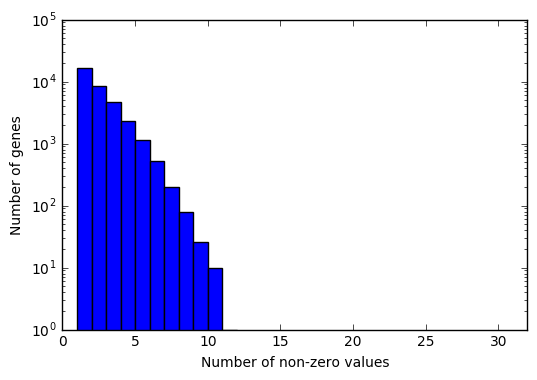

In [75]:
for key, value in nonzerovalues.items():
    if value == 0:
        display.display(key, X[key])
        break

# plot histogram of how many non-zero values the features contain
plt.hist(list(nonzerovalues.values()), bins = range(len(X)))
plt.ylabel('Number of genes')
plt.yscale('log')
plt.xlabel('Number of non-zero values')
plt.xlim(0, len(X))
plt.show()

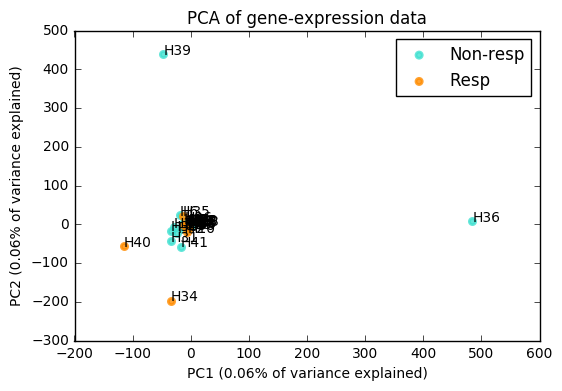

In [12]:
pca = PCA(n_components = 2)
X_r = pd.DataFrame(pca.fit(X).transform(X), index = X.index)

plt.figure()
colors = ['turquoise', 'darkorange']
target_names = ['Non-resp', 'Resp']
label = [float(x.replace('H','')) for x in X_r.index]
for color, target_name in zip(colors, target_names):
    plt.scatter(X_r[y == target_name][0], X_r[y == target_name][1], color=color, alpha=.8, lw=2, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel('PC1 ({0:.2f}% of variance explained)'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({0:.2f}% of variance explained)'.format(pca.explained_variance_ratio_[1]))
plt.title('PCA of gene-expression data')
for i, txt in enumerate(label):
    plt.annotate('H'+str(int(txt)), (X_r[0][i],X_r[1][i]))
plt.show()

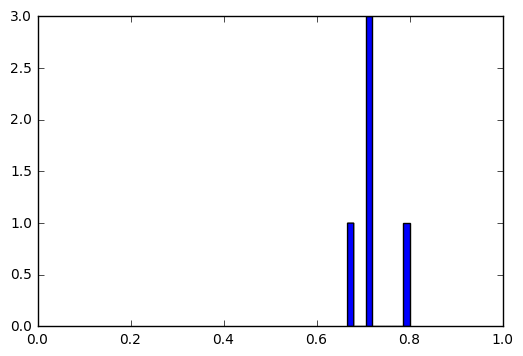

[0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.66666666666666663, 0.80000000000000004] 0.721904761905 0.0431839392334


In [73]:
features = []
accuracies = []
skf = StratifiedKFold(n_splits=5)
rfc = RandomForestClassifier(n_estimators = 100, n_jobs=-1, random_state=0)

for train_index, test_index in skf.split(X, y):    
    X_train = X.iloc[train_index].values
    X_test = X.iloc[test_index].values
    y_train = y[train_index].values
    y_test = y[test_index].values
    rfc.fit(X_train, y_train)
    accuracies.append(rfc.score(X_test, y_test))
    features.append(rfc.feature_importances_)
    
plt.figure()
plt.hist(accuracies)
plt.xlim(0, 1)
plt.show()

print(accuracies) 
print(np.mean(accuracies), np.std(accuracies))

gene75_0_3       0.004143
gene35165_3_7    0.003655
gene18921_0_3    0.003625
gene38015_3_7    0.003388
gene9061_0_7     0.003339
gene17683_0_3    0.003296
gene23106_0_7    0.003279
gene34387_0_7    0.003213
gene35451_0_7    0.003179
gene28993_0_3    0.003143
gene11990_3_7    0.003048
gene40514_0_7    0.003014
gene19695_0_3    0.003010
gene258_3_7      0.002968
gene44882_0_7    0.002959
gene23157_0_3    0.002893
gene14530_3_7    0.002738
gene44393_0_3    0.002714
gene4642_0_7     0.002677
gene39112_0_7    0.002641
gene23363_0_3    0.002636
gene30359_0_3    0.002618
gene49381_3_7    0.002555
gene38879_0_7    0.002548
gene45369_0_7    0.002465
gene40083_3_7    0.002408
gene43084_0_7    0.002407
gene35103_3_7    0.002376
gene10813_0_3    0.002373
gene39623_0_7    0.002369
                   ...   
gene49953_0_3    0.000265
gene48512_0_7    0.000261
gene1064_0_3     0.000260
gene1769_0_3     0.000260
gene10180_0_7    0.000258
gene4832_0_7     0.000257
gene5734_3_7     0.000257
gene25652_3_

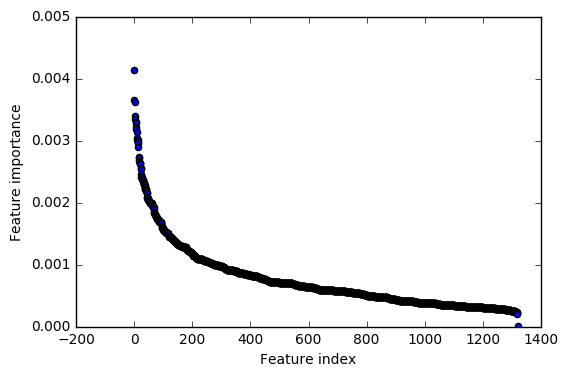

In [89]:
    #print(accuracies, np.mean(accuracies), np.std(accuracies)
    feature_df = pd.DataFrame(features).rename(columns = {i: X.columns[i] for i in range(len(X.columns))})
    feature_df = feature_df.append(feature_df.sum(), ignore_index=True)
    mean_feature_importance = feature_df.dropna().iloc[5].apply(lambda x: x/5).sort_values(ascending=False)
    mean_feature_importance = mean_feature_importance[mean_feature_importance != 0]
    print(mean_feature_importance)
    
    plt.scatter(y=mean_feature_importance.values, x=[i for i in range(len(mean_feature_importance))])
    plt.ylim(0, 0.005)
    plt.ylabel('Feature importance')
    plt.xlabel('Feature index')
    plt.show()